# Multivariate Time Series Forecasting with LSTMs in Keras
#### https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

### Train On Single Lag Timesteps

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 


Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 


In [7]:
# load dataset
dataset = read_csv('DFS04690650.txt', header=0, index_col=0)
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[10,11,12,14,15,16,17,18,19]], axis=1, inplace=True)
print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.548611        0.0        0.0        0.0        0.0   0.909091   
2   0.559028        0.0        0.0        0.0        0.0   0.909091   
3   0.569444        0.0        0.0        0.0        0.0   0.909091   
4   0.579861        0.0        0.0        0.0        0.0   0.909091   
5   0.581597        0.0        0.0        0.0        0.0   0.909091   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var4(t)  
1   0.666667   0.010526        0.0         0.0      0.0  
2   0.666667   0.021053        0.0         0.0      0.0  
3   0.666667   0.031579        0.0         0.0      0.0  
4   0.666667   0.042105        0.0         0.0      0.0  
5   0.666667   0.052632        0.0         0.0      0.0  


In [14]:
# split into train and test sets
values = reframed.values
n_train_periods = int(len(values)*0.8)
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 


(16243, 1, 10) (16243,) (4061, 1, 10) (4061,)


Train on 16243 samples, validate on 4061 samples
Epoch 1/50
 - 2s - loss: 0.0085 - val_loss: 0.0122
Epoch 2/50
 - 1s - loss: 0.0040 - val_loss: 0.0027
Epoch 3/50
 - 1s - loss: 0.0034 - val_loss: 0.0074
Epoch 4/50
 - 1s - loss: 0.0021 - val_loss: 0.0034
Epoch 5/50
 - 1s - loss: 0.0026 - val_loss: 0.0057
Epoch 6/50
 - 1s - loss: 0.0022 - val_loss: 0.0013
Epoch 7/50
 - 1s - loss: 0.0023 - val_loss: 0.0105
Epoch 8/50
 - 1s - loss: 0.0022 - val_loss: 0.0088
Epoch 9/50
 - 1s - loss: 0.0024 - val_loss: 0.0022
Epoch 10/50
 - 1s - loss: 0.0016 - val_loss: 0.0065
Epoch 11/50
 - 1s - loss: 0.0026 - val_loss: 0.0015
Epoch 12/50
 - 1s - loss: 0.0021 - val_loss: 0.0080
Epoch 13/50
 - 1s - loss: 0.0019 - val_loss: 0.0076
Epoch 14/50
 - 1s - loss: 0.0022 - val_loss: 0.0040
Epoch 15/50
 - 1s - loss: 0.0014 - val_loss: 0.0015
Epoch 16/50
 - 1s - loss: 0.0025 - val_loss: 0.0032
Epoch 17/50
 - 1s - loss: 0.0013 - val_loss: 0.0018
Epoch 18/50
 - 1s - loss: 0.0022 - val_loss: 0.0037
Epoch 19/50
 - 1s - loss

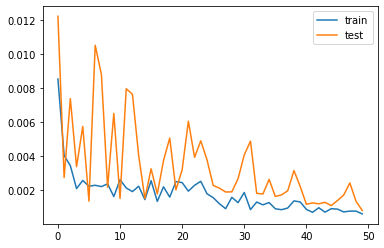

In [16]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
#pyplot.show()
 


In [17]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.029


### Train On Multiple Lag Timesteps

(20209, 970)
(16167, 960) 16167 (16167,)
(16167, 96, 10) (16167,) (4042, 96, 10) (4042,)
Train on 16167 samples, validate on 4042 samples
Epoch 1/50
 - 30s - loss: 0.1201 - val_loss: 0.0810
Epoch 2/50
 - 33s - loss: 0.0610 - val_loss: 0.0644
Epoch 3/50
 - 33s - loss: 0.0497 - val_loss: 0.0662
Epoch 4/50
 - 33s - loss: 0.0428 - val_loss: 0.0497
Epoch 5/50
 - 33s - loss: 0.0364 - val_loss: 0.0369
Epoch 6/50
 - 32s - loss: 0.0233 - val_loss: 0.0249
Epoch 7/50
 - 31s - loss: 0.0189 - val_loss: 0.0385
Epoch 8/50
 - 32s - loss: 0.0184 - val_loss: 0.0380
Epoch 9/50
 - 32s - loss: 0.0179 - val_loss: 0.0393
Epoch 10/50
 - 32s - loss: 0.0159 - val_loss: 0.0241
Epoch 11/50
 - 32s - loss: 0.0144 - val_loss: 0.0239
Epoch 12/50
 - 31s - loss: 0.0144 - val_loss: 0.0182
Epoch 13/50
 - 31s - loss: 0.0150 - val_loss: 0.0474
Epoch 14/50
 - 31s - loss: 0.0139 - val_loss: 0.0135
Epoch 15/50
 - 31s - loss: 0.0136 - val_loss: 0.0312
Epoch 16/50
 - 31s - loss: 0.0154 - val_loss: 0.0277
Epoch 17/50
 - 31s - lo

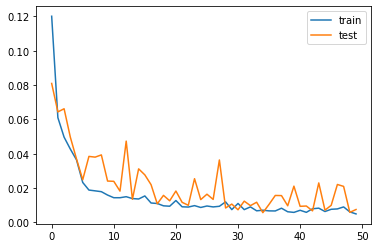

In [27]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('DFS04690650.txt', header=0, index_col=0)
values = dataset.values
# integer encode direction
#ncoder = LabelEncoder()
#alues[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag periods
n_periods = 4*24
n_features = 10
# frame as supervised learning
reframed = series_to_supervised(scaled, n_periods, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_periods = int(len(values)*0.8)
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]
# split into input and outputs
n_obs = n_periods * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_periods, n_features))
test_X = test_X.reshape((test_X.shape[0], n_periods, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=4*24, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



In [28]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_periods*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -9:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -9:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.388
